# Подготовка данных для предсказания и замены чисел вместо пропусков

## Импорт библиотек

In [1]:
!pip install miceforest

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import miceforest as mf
from sklearn.base import clone
from itertools import combinations
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_percentage_error

##Функции/Классы

### **функции**

In [3]:
def super_train_test_split(df: pd.DataFrame, y: pd.Series):
    '''
    Делит данные на две выборки: 1. строки, значения необходимого нам столбца не имеют пропусков.
                                2. строки, значения необходимого нам столбца имеют пропуски.
    Каждый из этих пунктов так же делиться на две выборки: а) необходимый столбец.
                                                            б) остальные факторы.

    Аргументы:
        df: Pandas DataFrame, состоящий из факторов, инмеющих зависимость с признаком,
            в котором необходимо заполнить пропуски.

        y: Pandas Series, признак, пропуски которого необходимо заполнить.

    небольшой комментарий:
    У нас есть проблема - для заполенния пропусков с помощью какой-либо модели, необходимо,
    чтобы ВСЕ значения в других признаках были заполнены(не было пропусков).
    В противном случае модель ругается, что есть NaNы. Данный цикл устраняет данную проблему,
    временно заполняя пропуски в столбцах на медиану всех значений признака
    (кроме столбца, задача для которого изначально была заполнить пропуски с помощью модели).
    Дальше смотрите по комментариям
    '''
    X = df.copy()

    y_train = y[y.isnull() == False] # отбираем для тренировки те строки, в которых присутсвуют данные
    y_temp = y[y.isnull()] # просто мусор. Полезный

    idxs = y_temp.index # берём иднексы мусора(индексы,
                      # в строках которых есть пропуски, которые необходимо заполнить)
    X_train = X.drop(idxs) # делаем обучающую выборку из строк, в которых нет пропусков

    idxs = y_train.index # берём иднексы c изначально заполенными значениями
    X_test = X.drop(idxs) # отбрасываем строки с заполненными значениями в нужном нам столбце.
                        # Получается выборка с данными, на основе которых будут
                        # предсказываться пропущенные значения



    return X_train, X_test, y_train, y_temp


####################################################################################################


def split_for_grade(df: pd.DataFrame, target_column: pd.Series): # просто раздел данных на
                                                                 # выборки для обучения и тестирования
    X = df.copy()

    if target_column.name in X.columns:
        X.pop(target_column.name)
    y = target_column
    y1 = y[y.isnull() == False] # отбираем для тренировки те строки, в которых присутсвуют данные
    y_temp = y[y.isnull()] # просто мусор. Полезный

    idxs = y_temp.index # берём иднексы мусора(индексы,
                      # в строках которых есть пропуски, которые необходимо заполнить)
    X = X.drop(idxs) # делаем обучающую выборку из строк, в которых нет пропусков
    X = X.reset_index(drop=True)

    kernel = mf.ImputationKernel(
        data=X,
        random_state=42
    )
    y1 = y1.reset_index(drop=True)

    kernel.mice(iterations=1) # Количество итерация

    # Получаем датафрейм без пропусков
    X = kernel.complete_data()


    X_train, X_test, y_train, y_test = train_test_split(
        X, y1, test_size=0.2, random_state=42)
    return X_train.values, X_test.values, y_train.values, y_test.values

### **Классы**

In [4]:
class SBS():
    """
    Класс для последовательного обратного отбора признаков (Sequential Backward Selection).

    Алгоритм отбирает подмножество наиболее важных признаков,
    оптимизируя модель по метрикам качества (R-квадрат и MSE).

    Аргументы:
        estimator: Модель машинного обучения, которую нужно оптимизировать.
                   Должна поддерживать методы fit и predict.
        k_features: Целевое количество признаков для отбора.
        test_size: Доля данных для тестирования (кросс-валидация).
        random_state: Случайное зерно для воспроизводимости результатов.

    """
    def __init__(self, estimator, k_features,
                test_size=0.25, random_state=42):
        # Создаём копию модели, чтобы случайно не изменить исходную.
        self.estimator = clone(estimator)
        self.k_features = k_features
        self.test_size = test_size
        self.random_state = random_state

    def fit(self, X, y, own_split=False):
        """
        Обучает модель SBS и отбирает лучшие признаки.

        Аргументы:
            X: Матрица признаков.
            y: Вектор целевой переменной.
            own_split: Если True, использует пользовательскую функцию split_for_grade для разделения данных.
        """

        # Разделение данных на обучающую и тестовую выборки.
        X_train, X_test, y_train, y_test = split_for_grade(X, y)


        dim = X_train.shape[1]

        self.indices_ = list(range(dim))  # Индексы всех признаков.
        self.subsets_ = [self.indices_] # Список всех подмножеств признаков.

        # Вычисляем R-SQUARED и MSE.
        score = self._calc_score(X_train, y_train,
                                    X_test, y_test, self.indices_)
        self.scores_ = [score]

        while dim > self.k_features:
            scores = []
            subsets = []

            # Перебор всех возможных подмножеств с одним удаленным признаком.
            for p in combinations(self.indices_, r=dim - 1):
                score = self._calc_score(X_train, y_train,
                                            X_test, y_test, p)
                scores.append(score)
                subsets.append(p)

            # находим подмножества с лучшими значениями метрик
            best = np.argmax([i[0] for i in scores]) # Выбираем подмножество с наибольшим r2_score,
                                                     # т.к. данная метрика в приоритете. Так же отбор
                                                     # лучшей комбинации будет происходит вне класса.
            self.indices_ = subsets[best]
            self.subsets_.append(self.indices_)
            dim -= 1

            self.scores_.append(scores[best])
        self.k_score_ = self.scores_[-1]

        return self

    def _calc_score(self, X_train, y_train, X_test, y_test, indices):
        """
        Вычисляет метрики R-SQUARED и MSE для заданного подмножества признаков.

        Аргументы:
            X_train, y_train, X_test, y_test, indices: Данные для обучения и оценки модели.
        """
        self.estimator.fit(X_train[:, indices], y_train) # Обучение выбранной модели.

        y_pred = self.estimator.predict(X_test[:, indices]) # Предсказание значений.

        # Оценивание предсказаний метриками R2 и MSE
        score = [r2_score(y_test, y_pred), mean_absolute_percentage_error(y_test, y_pred)]
        return score


## Инициализация моделей и главного дата фрейма

инициализация моделей и методов

In [5]:
knn_model = KNeighborsRegressor(n_neighbors=3)
random_forest = RandomForestRegressor(random_state=42)
scaler = MinMaxScaler()

In [6]:
df_environmental_data = pd.read_csv("../analysing_environmental_issues.csv", sep=',') # главный датафрейм

### Обработка выбросов

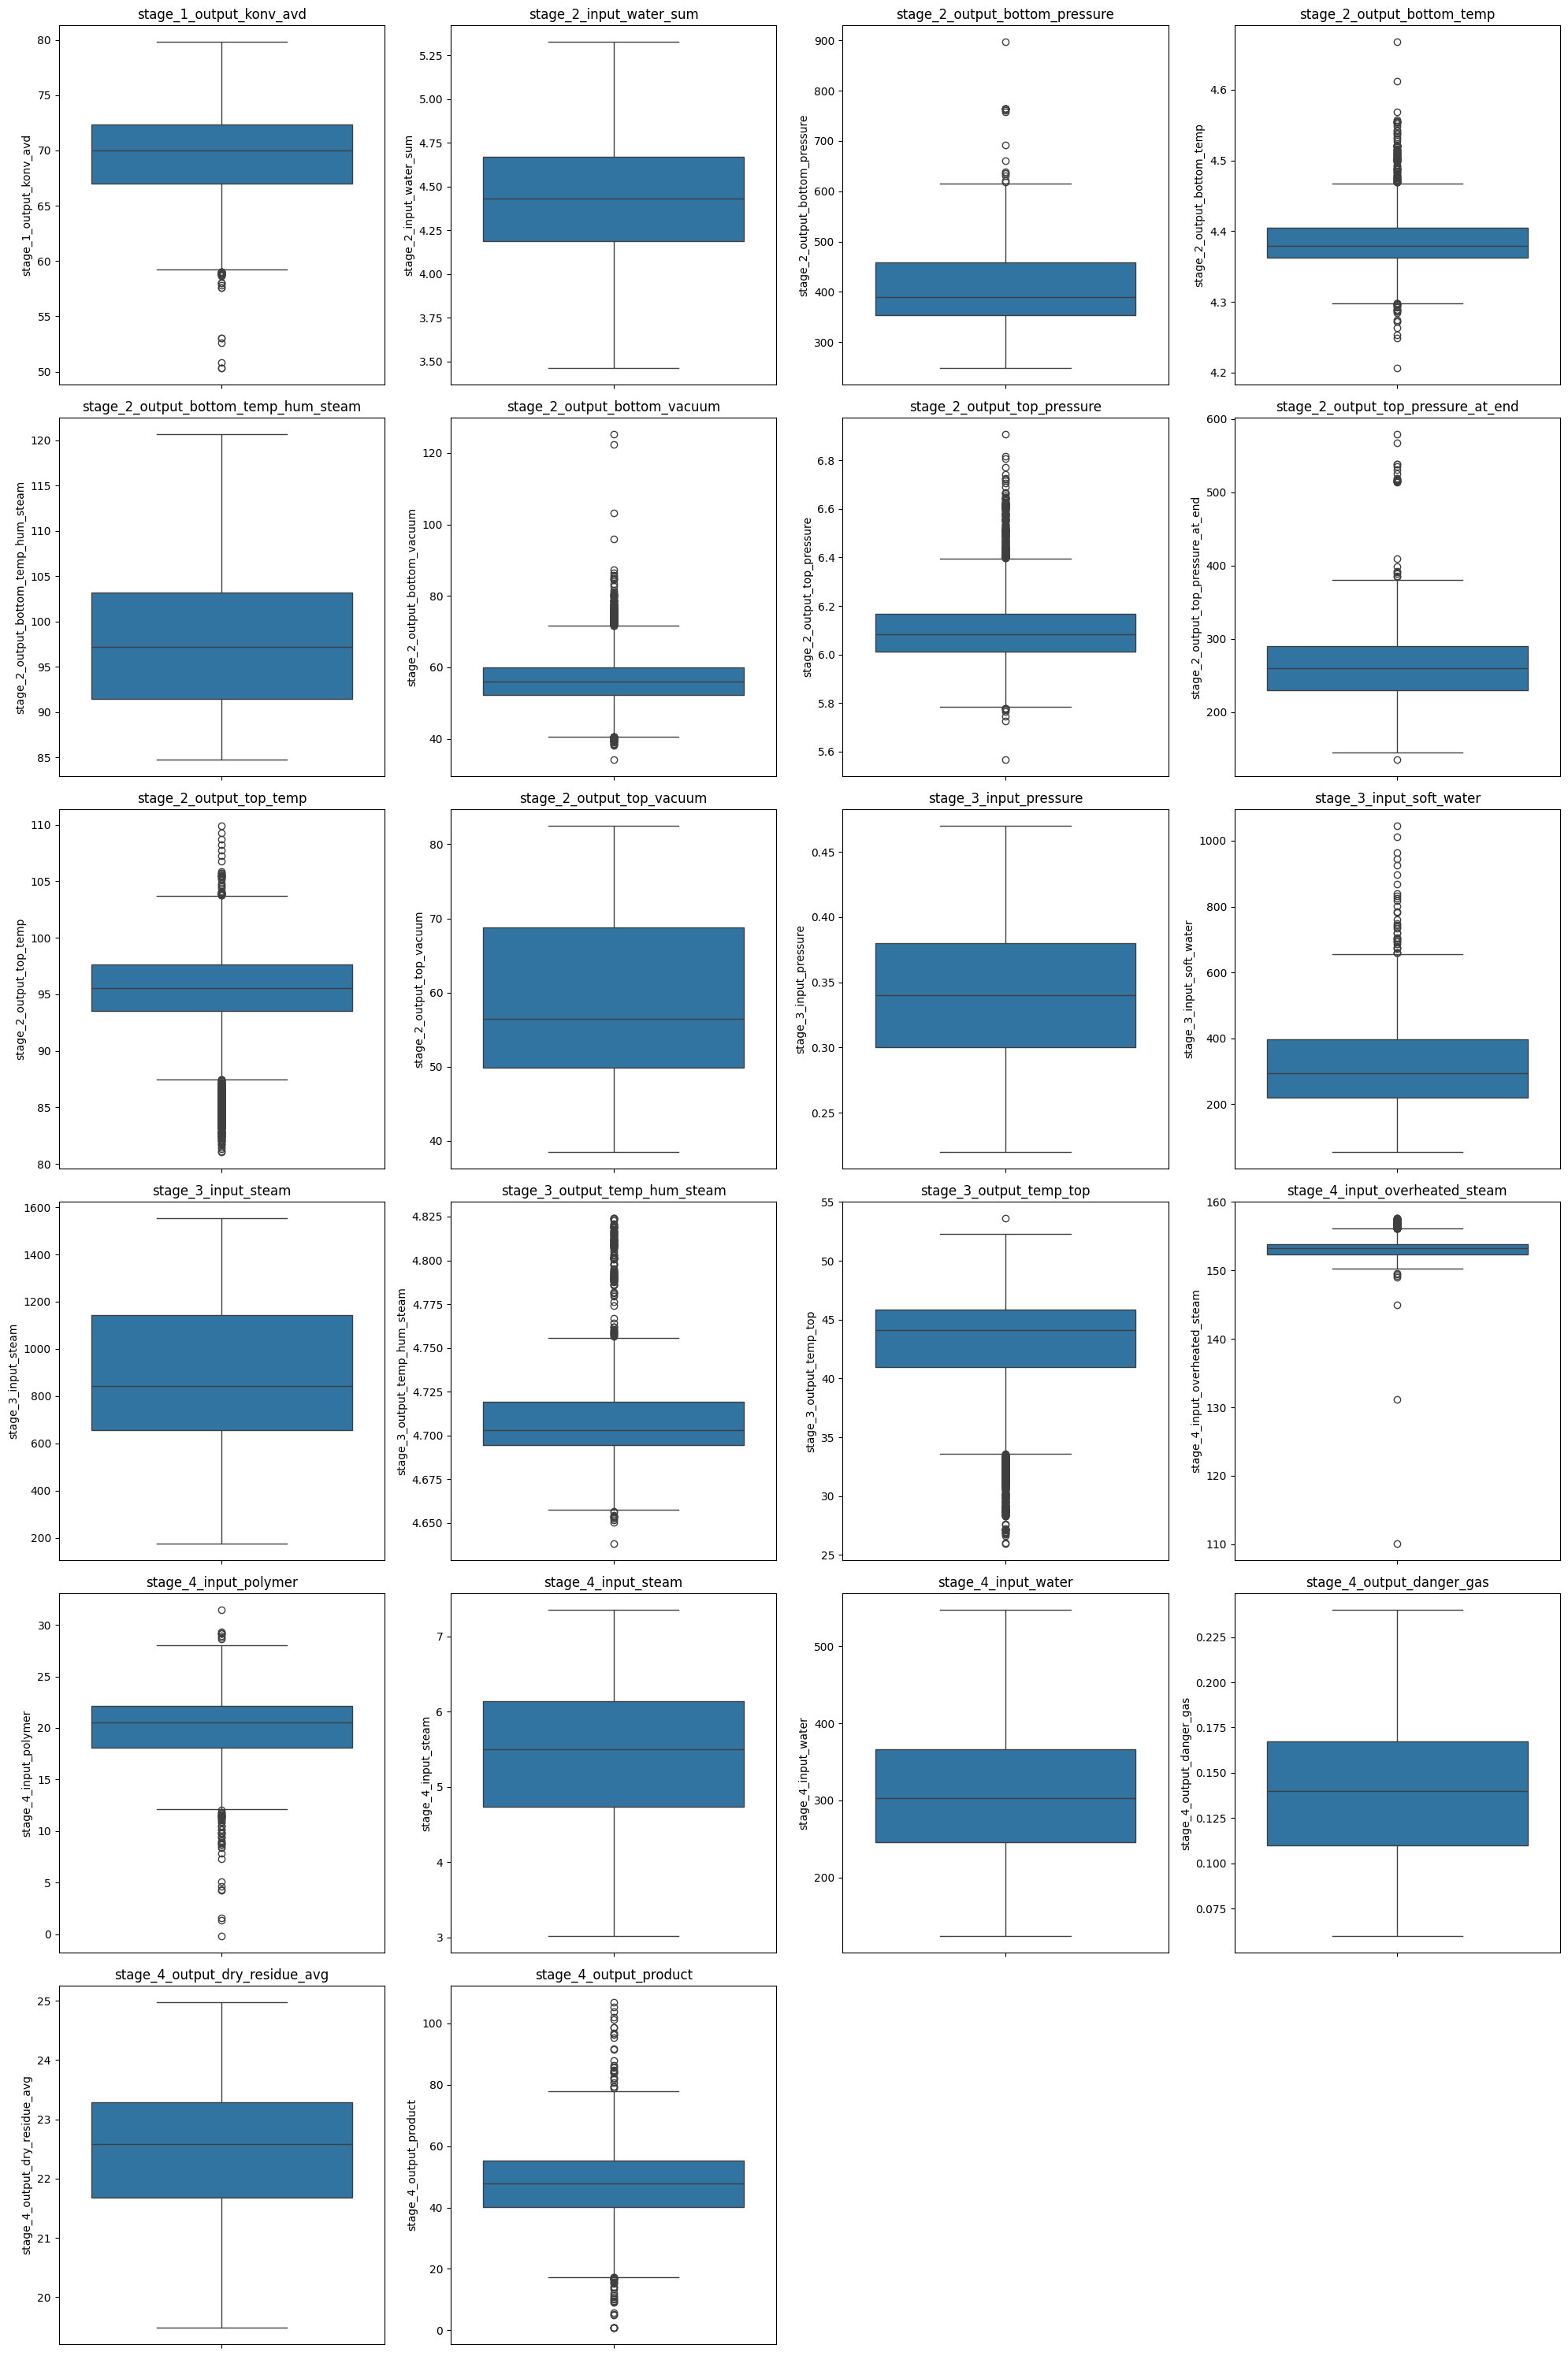

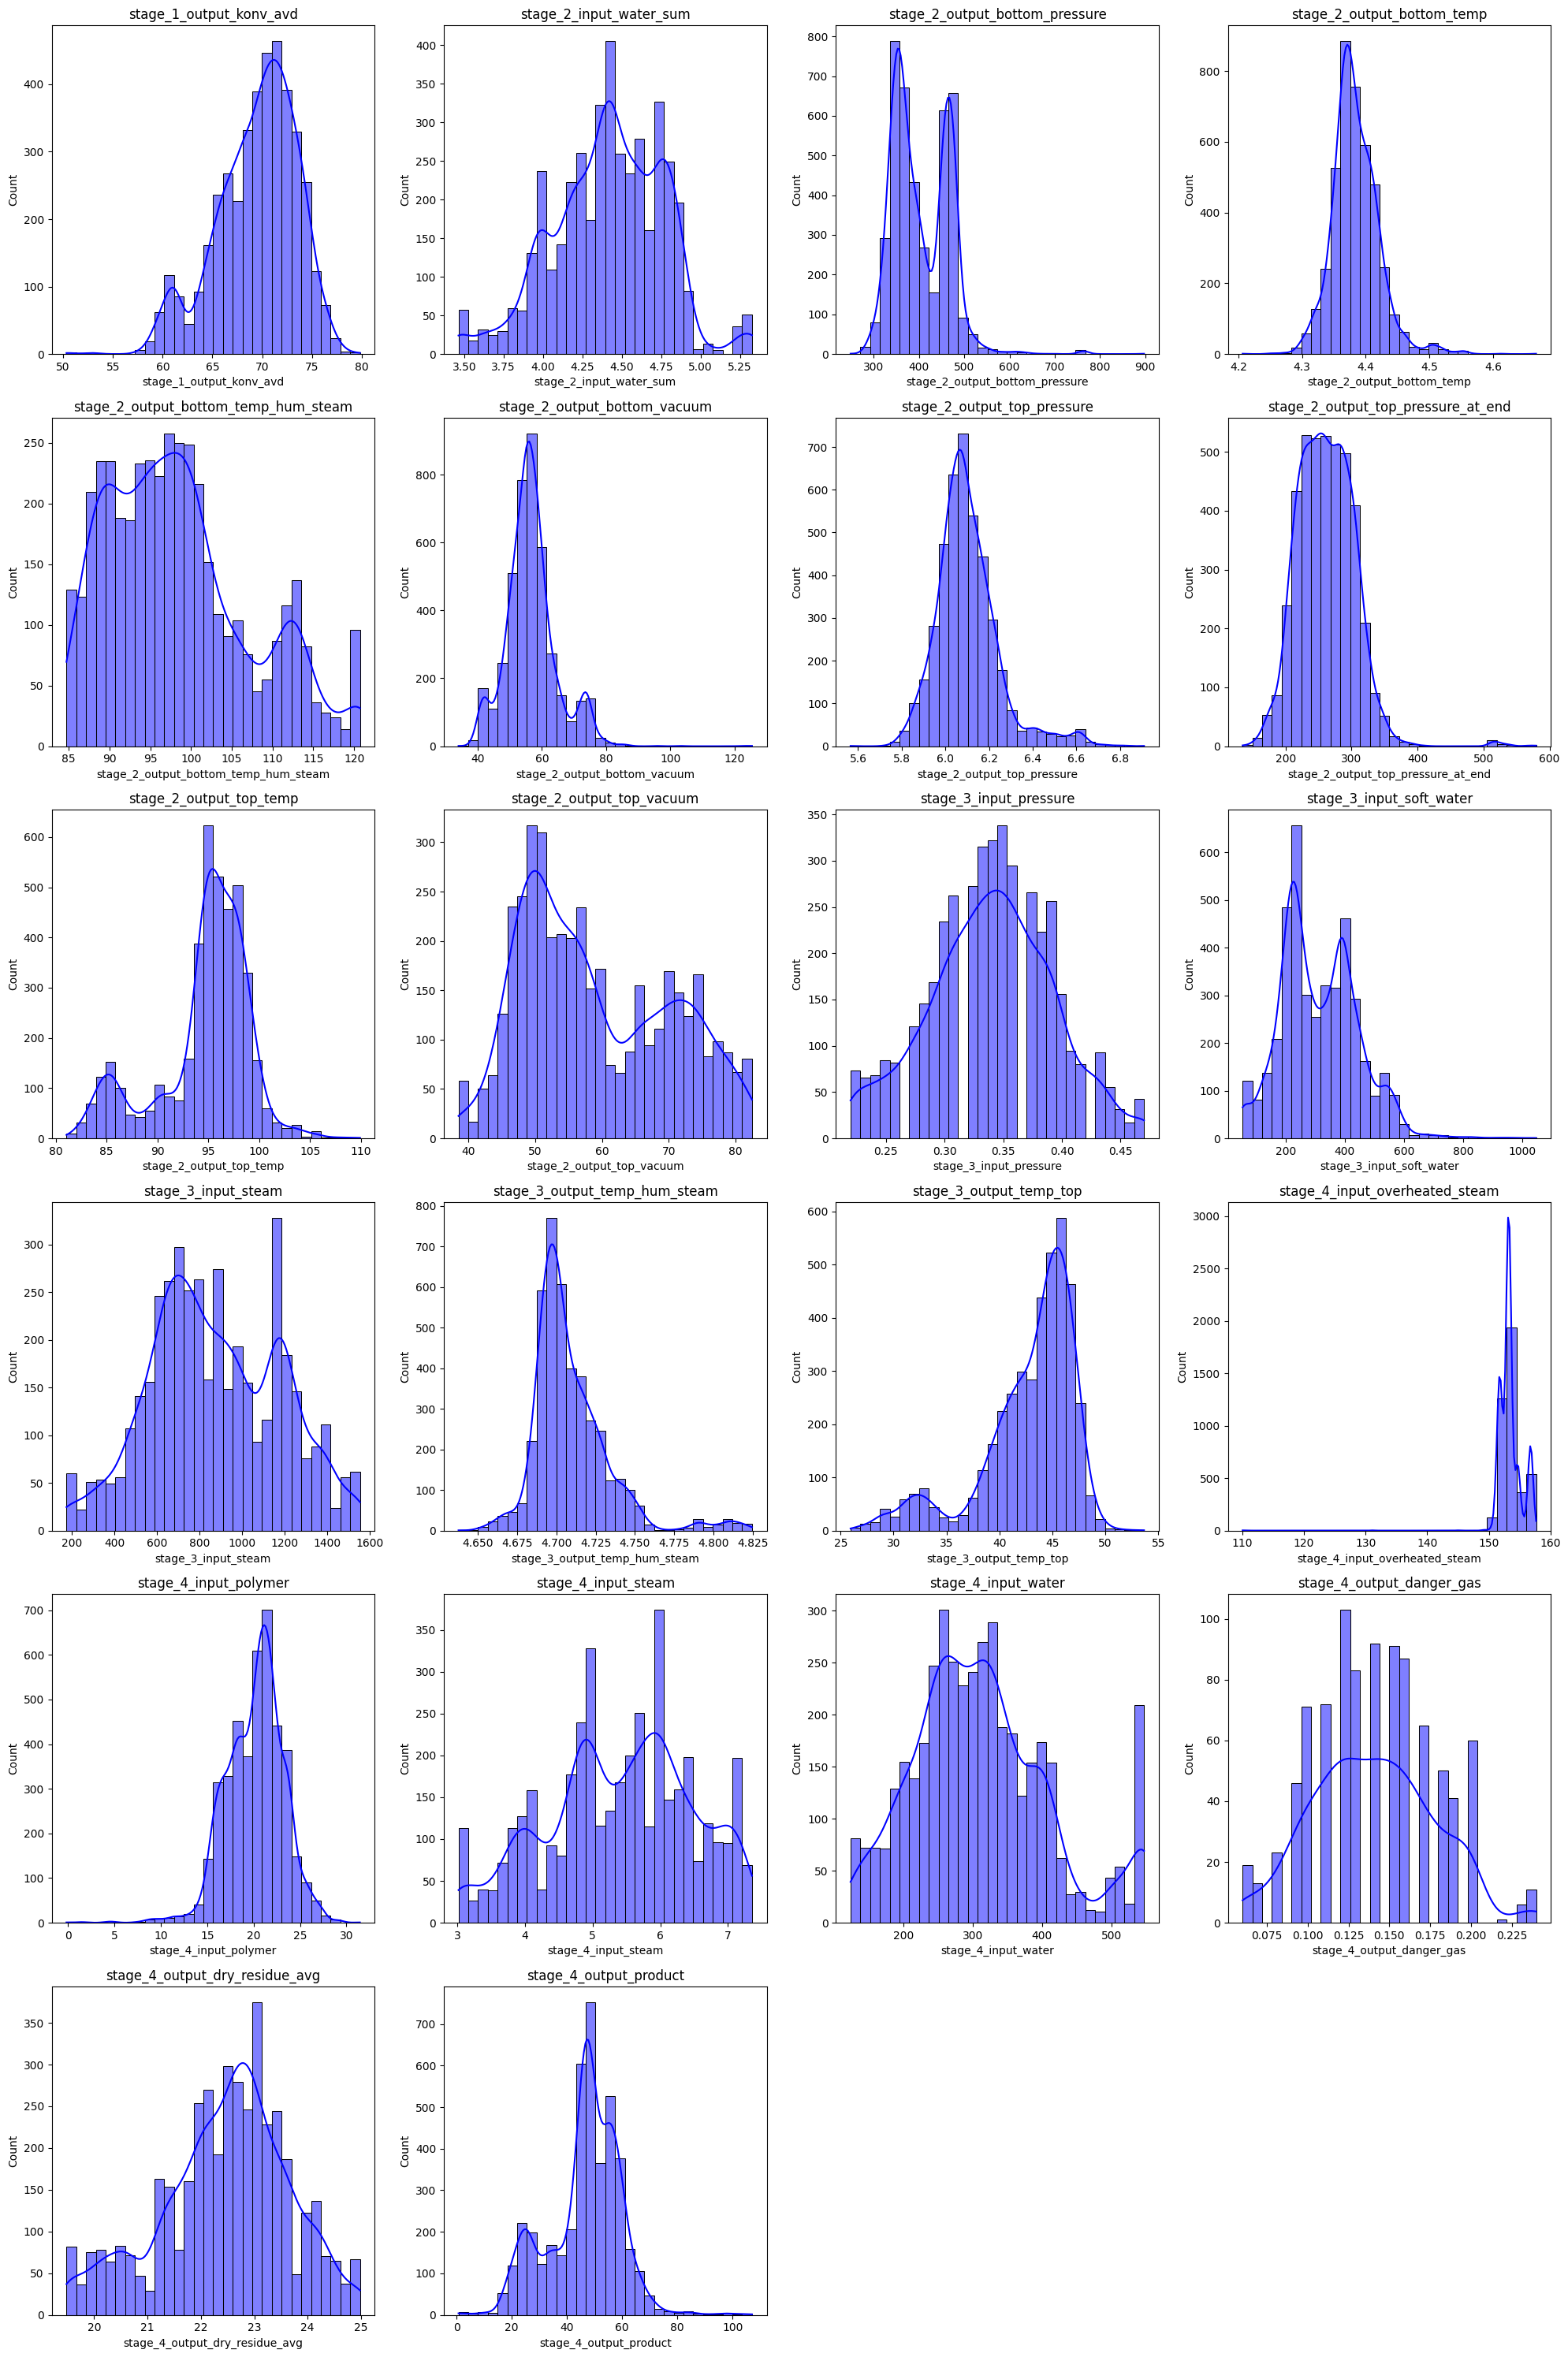

In [7]:
df = df_environmental_data.copy()

%run remove_outliers_run.ipynb

df = hybrid_outlier_handling(df, df.columns[1:])
# Для проверки, что все работает
draw_boxplots_for_all_columns(df)
draw_histograms_for_all_columns(df)

## предобработка перед оценкой моделей и предсказыванием значений

Перевод типов признаков в другие, удаление дубликатов

Анализуря данные, выведенные в таблице выше, можно заметить болшие диапазоны значений, которые могут плохо повлиять на обучение модели и предсказание пропущенных значений, поэтому необходимо выполнить нормализацию данных.

известно, что столбец "DateTime" имеет неправильный тип данных, но его можно привести в числовой вид в диапазоне от 0 до 1, чтобы использовать в качестве фактора.

признак "stage_4_output_danger_gas" имеет большое количество пропущенных значений, поэтому он может плохо влиять на результаты и оценку метрик. Удалим его.

In [8]:
df['DateTime'] = pd.to_datetime(df['DateTime'], errors='coerce')
time_diffs = df['DateTime'].diff().dt.total_seconds()
time_diffs = time_diffs.fillna(0)

# нормализуем даты из столбца DateTime
normalized_diffs = scaler.fit_transform(time_diffs.values.reshape(-1, 1)).flatten()

# вычисляет кумулятивную сумму элементов
normalized_times = np.cumsum(normalized_diffs)

# подставляем нормализованные значение
df['DateTime'] = normalized_times
df.pop("stage_4_output_danger_gas") # значений мало, признак на данном этапе бесполезный.

# Признак имеет категориальный тип данных. Для избежания проблем конвертируем значения в числовой тип
df['work_shift'] = np.where(df['work_shift'] == 1.0, 0, 1)

df.head(5)

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_input_steam,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
0,0.000000,67.83,4.543188,474.18,4.354655,97.52,49.94,5.893024,252.04,97.48,...,664.93,4.697293,45.59,156.67,19.08,5.92,356.05,21.48,47.03,1
1,0.000413,67.83,4.530662,473.68,4.345752,97.82,48.55,5.874228,244.87,97.66,...,671.68,4.697841,45.89,156.76,19.15,5.94,357.69,21.48,45.05,1
2,0.000826,67.83,4.517977,473.17,4.336768,98.12,47.15,5.855072,237.70,97.85,...,678.44,4.698296,46.19,156.86,19.23,5.97,359.33,21.48,43.06,1
3,0.001239,67.93,4.513493,473.59,4.334149,97.79,49.33,5.879806,249.87,97.50,...,717.99,4.697111,45.87,156.41,19.36,5.97,339.99,21.48,46.01,1
4,0.001652,68.03,4.509100,474.00,4.331523,97.46,51.51,5.903971,262.04,97.15,...,757.55,4.696016,45.54,155.96,19.49,5.97,320.64,21.48,48.95,1


При поиске дубликатов было замечено, что все одинаковые строки данных, не считая признак DateTime, не содержат в себе данные, поэтому разумным действием будет их удаления

In [9]:
df[df.duplicated(subset=df.columns[1:])].head(10)

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_input_steam,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
1117,2.916976,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1141,2.926890,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1165,2.936803,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1182,2.946716,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1206,2.956629,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1230,2.966543,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1254,2.976456,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1278,2.986369,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1302,2.996283,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1
1326,3.006196,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1


In [10]:
# Очень важно, что дубликаты будут найдены, если игнорировать столбец "DateTime".
df = df.drop_duplicates(subset=df.columns[1:], keep=False) # удаляем все дубликаты.

In [11]:
df[df.duplicated()]

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_input_steam,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift


In [12]:
df.describe()

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_input_steam,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift
count,4240.000000,4159.000000,4177.000000,4180.000000,4209.000000,4223.000000,4169.000000,4218.000000,4226.000000,4196.000000,...,4227.000000,4226.000000,4170.000000,4231.000000,4174.000000,4156.000000,4159.000000,4240.000000,4240.000000,4240.000000
mean,3.348423,69.456160,4.413929,404.030844,4.384028,98.443322,56.764406,6.101013,261.478121,94.630858,...,875.592890,4.709210,42.777156,153.448811,20.162808,5.399061,311.664799,22.443443,46.346776,0.483019
std,1.919090,4.032077,0.347977,62.018933,0.037072,8.733300,7.858853,0.144201,43.201651,4.541636,...,305.113641,0.024523,4.472304,1.759867,3.080904,1.063268,98.141562,1.211879,13.022949,0.499770
min,0.000000,50.330000,3.464106,248.760000,4.206631,84.727600,34.070000,5.565363,134.920000,81.050000,...,173.500000,4.637928,25.940000,110.040000,-0.170000,3.020000,124.000000,19.480000,0.710000,0.000000
25%,2.222945,67.030000,4.186924,353.252500,4.362207,91.450000,52.250000,6.013226,230.027500,93.550000,...,656.695000,4.694279,40.960000,152.330000,18.100000,4.740000,245.160000,21.680000,40.065000,0.000000
50%,3.644568,70.030000,4.429626,389.395000,4.379774,97.200000,56.070000,6.082128,259.660000,95.530000,...,844.150000,4.702887,44.100000,153.210000,20.510000,5.500000,303.390000,22.580000,47.870000,0.000000
75%,4.950537,72.330000,4.668802,458.350000,4.404888,103.155000,60.030000,6.166683,290.480000,97.620000,...,1144.395000,4.719101,45.860000,153.835000,22.130000,6.140000,366.005000,23.280000,55.310000,1.000000
max,7.749690,79.830000,5.326528,897.290000,4.667769,120.712500,125.360000,6.909504,579.640000,109.900000,...,1555.389000,4.824306,53.650000,157.680000,31.460000,7.354500,547.272500,24.980000,107.050000,1.000000


## **SBS  для выбора факторов , на основе которых буддет обучаться модель и предсказываться значения**

Данный алгоритм выбирает лучшую комбинацию факторов для каждого столбца, которые имеют пропуски в данных, исходя из оценок KNN алгоритма с помощью метрик R2 и MAPE. Полученная комбинация записывается в словарь  **columns_dict_NaN_for_predict** с названием признака в качестве ключа

In [13]:
columns_dict_NaN_for_predict = {} # 'column_name': [best_columns_combination]

In [14]:
# запись изначальных индексов строк в лист и последующий сброс индексов в датфрейме.
# Это необходимое действие, так как mouseforest выдаёт ошибку,
# если нарушен порядок индексов, что и было сделано при удалении дубликатов.
index_list = df.index.tolist()
index_series = pd.Series(index_list)
df = df.reset_index(drop=True)

In [15]:
#инициализируем алгоритм sbs.

# Было решено использовать минимальное k_features = 2 в SBS, чтобы улавливать взаимодействия признаков,
# избегать потери информации, обеспечивать стабильность модели, сравнивать комбинации,
# и основываться на практике, где комбинации обычно лучше,
# а также избежать чрезмерного сокращения признаков на ранних итерациях алгоритма.
# Это позволяет искать комбинацию признаков, а не один единственный.
sbs = SBS(knn_model, k_features=2)

#поиск лучшей комбинации признаков для каждого столбца в датафрейме.
for column in df.columns:
    if df[column].isnull().any() == False:
        continue

    # подготовка данных
    y = df[column]
    X = df.copy()
    X.pop(column)

    #для корректной работы необходимо перевести названия столбцов в численный вид.
    new_names = [i for i in range(len(df.columns))]

    #скармливаем данные алгоритму sbs.
    sbs.fit(X, y)

    #переименовываем название факторов в численный вид
    X = X.rename(columns=dict(zip(X, new_names)))

    #инициализируем переменные для отбора лучшей комбинации признаков
    best_r2 = -1
    best_mape = float('inf')
    best_pair = None
    lk = -1



    #в sbs.scores_ записываются оценки метрик за все проверенные комбинации
    #поэтому необходимо отобрать лучшие показатели.
    #В ходе тестирований и анализа было замечено, что при лучших значениях метрик mse/mape,
    #метрика R2 показываля очень хорошие значения, поэтому из этого было принято отбирать пары
    #признаков исходя из значений метрики mape.
    for i, (r2_sc, mape_sc) in enumerate(sbs.scores_):
        #простой, но допустимы отбор
        if mape_sc < best_mape:
            best_r2 = r2_sc
            best_mape = mape_sc

            best_pair = [best_r2, best_mape]

            #создание списка индексов признаков.
            lk = list(sbs.subsets_[sbs.scores_.index([best_r2, best_mape])])

    #Так как при создании списка индексов признаков не учитывается, что был удалён
    #столбец, относительно которого ведутся вычесления, необходимо отредактировать
    #созданный массив.
    if df.columns.get_loc(y.name) in lk:
        index = lk.index(df.columns.get_loc(y.name))
        lk = np.array(lk)

        if index < len(lk) - 1:
            lk = np.concatenate((lk[:index], lk[index:] + 1))
        else:
            lk = lk[:index]
    else:
        for i in range(len(lk)):
            if lk[i] > df.columns.get_loc(y.name):
                lk[i] += 1

    #вывод результатов вычеслений.
    print(column)
    print(f"набор индексов лучших факторов: {lk}")
    #MAPE может выдавать ошибочные большие значения, но это не влияет сильно на итоговый результат
    print(f"Лучшая пара метрик: R2 = {best_pair[0]:.4f}, MAPE = {best_pair[1]:.4f}")
    print('=-----------------------------------------------')

    columns_dict_NaN_for_predict[column] = [col for col in list(df.columns[0:][lk]) if col != column]

#вывод итогового словаря
print(columns_dict_NaN_for_predict)


stage_1_output_konv_avd
набор индексов лучших факторов: [ 0  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Лучшая пара метрик: R2 = 0.7308, MAPE = 0.0205
=-----------------------------------------------
stage_2_input_water_sum
набор индексов лучших факторов: [ 1  3  5  6  8  9 10 12 13 15 16 19 21]
Лучшая пара метрик: R2 = 0.8307, MAPE = 0.0162
=-----------------------------------------------
stage_2_output_bottom_pressure
набор индексов лучших факторов: [ 0  1  2  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22]
Лучшая пара метрик: R2 = 0.8068, MAPE = 0.0273
=-----------------------------------------------
stage_2_output_bottom_temp
набор индексов лучших факторов: [ 0  2  3  5  6  7  9 10 11 14 15 16 17 18 20 22]
Лучшая пара метрик: R2 = 0.9684, MAPE = 0.0007
=-----------------------------------------------
stage_2_output_bottom_temp_hum_steam
набор индексов лучших факторов: [ 0  1  3  4  6  7  8  9 10 11 12 13 14 15 16 18 19 21]
Лучшая пара метрик: R2 = 0.802

# Замена пропущенных значений

Для макисимально точного предсказания значений и качественного обучения модели было принято использовать две модели: KNN и RFR. Пропуски в данных, которые будут служить факторами для обучения и предсказания, заменяются на значения с MICE. Будет вестись запись метрик каждой модели для последующего нахождения лучшего варианта замены пропусков в каждом столбце.

Были использованы именно эти модели, потому что KNN показал свою эффективность в отборе факторов для обучения модели, а RFR является отличным вариантом для нахождения нелинейных зависимостей, обработки высокоразмерных данных.

In [16]:
#df

In [17]:
df1 = df.copy() # чек-поинт

In [18]:
df = df1.copy() # загрузка последнего сохранения

Создаём временный датафрейм **df_temp** и заполняем пропуски с помощью MICE. Данный датафрейм будет корректироваться после получения новых предсказаний модели.

In [19]:
df_temp = df.copy()
kernel = mf.ImputationKernel(
    data=df_temp,
    random_state=42
)

kernel.mice(iterations=5)

# Получаем временный датафрейм без пропусков
df_temp = kernel.complete_data()

In [20]:
#создаём временную копию главного датафрейма.
df_without_nan_by_cnn = df.copy()

#словарь со значениями метрики r2 каждого столбца,
#в котором обнаружены пропуски
metrics_by_cnn = {}

In [21]:
for column in columns_dict_NaN_for_predict.keys(): # для каждого столбца в котором остались пропущенные значения

    X = df_temp.loc[:, columns_dict_NaN_for_predict[column]].copy() # все зависимые признаки с столбцом column ()
    y = df_without_nan_by_cnn[column] # наш столбец.


    y_for_grade = y[y.isnull() == False] # отбираем для тренировки те строки, в которых присутсвуют данные
    y_temp = y[y.isnull()] # просто мусор. Полезный

    idxs = y_temp.index # берём иднексы мусора(индексы,
                      # в строках которых есть пропуски, которые необходимо заполнить)
    X_for_grade = X.drop(idxs) # делаем обучающую выборку из строк, в которых нет пропусков

    X_train, X_test, y_train, y_temp = train_test_split(X_for_grade, y_for_grade, test_size=0.2, random_state=42) # Делим наши данные на
                                                                    # на обучающую и тестовую выборку
    knn_model.fit(X_train, y_train) # обучаем модель knn(для каждого столбца)
    y_pred = knn_model.predict(X_test) # предсказываем пропущенные значения

    #оценка модели
    r2 = r2_score(y_temp, y_pred)
    mse = mean_squared_error(y_temp, y_pred)

    metrics_by_cnn[column] = [r2] #запись оценку метрики r2 в словарь

    print("-" * 50)
    print(f'{column} -> r2: {r2}, mse: {mse}')


    X_train, X_test, y_train, y_temp = super_train_test_split(X, y) # Делим наши данные на
                                                                    # на обучающую и тестовую выборку
    knn_model.fit(X_train, y_train) # обучаем модель knn(для каждого столбца)

    y_pred = knn_model.predict(X_test) # предсказываем пропущенные значения

    df_without_nan_by_cnn.loc[X_test.index, column] = y_pred # вставляем предсказания на места пропущенных значений
    df_temp.loc[X_test.index, column] = y_pred # вставляем предсказания на места пропущенных значений для более точных предсказаний

--------------------------------------------------
stage_1_output_konv_avd -> r2: 0.7369542157086035, mse: 4.188713942307692
--------------------------------------------------
stage_2_input_water_sum -> r2: 0.8442812766556725, mse: 0.01919611173270118
--------------------------------------------------
stage_2_output_bottom_pressure -> r2: 0.814458742377647, mse: 771.3352786283891
--------------------------------------------------
stage_2_output_bottom_temp -> r2: 0.968703126860392, mse: 4.1931378504671496e-05
--------------------------------------------------
stage_2_output_bottom_temp_hum_steam -> r2: 0.7877965376620935, mse: 16.04055526879027
--------------------------------------------------
stage_2_output_bottom_vacuum -> r2: 0.9033060732725668, mse: 6.298777431388221
--------------------------------------------------
stage_2_output_top_pressure -> r2: 0.8835491306440194, mse: 0.002198989327317803
--------------------------------------------------
stage_2_output_top_pressure_at_end

In [22]:
df = df1.copy() # загрузка последнего сохранения

In [23]:
#аналогичные действия были описаны выше
df_temp = df.copy()
kernel = mf.ImputationKernel(data=df_temp, random_state=42)
kernel.mice(iterations=5)
df_temp = kernel.complete_data()

In [24]:
#создаём временную копию главного датафрейма.
df_without_nan_by_rfr = df.copy()

#словарь со значениями метрики r2 каждого столбца,
#в котором обнаружены пропуски
metrics_by_rfr = {}

In [25]:
for column in columns_dict_NaN_for_predict.keys(): # для каждого столбца в котором остались пропущенные значения
    y = df_without_nan_by_rfr[column] # наш столбец.
    X = df_temp.loc[:, columns_dict_NaN_for_predict[column]].copy()

    y_for_grade = y[y.isnull() == False] # отбираем для тренировки те строки, в которых присутсвуют данные
    y_temp = y[y.isnull()] # просто мусор. Полезный

    idxs = y_temp.index # берём иднексы мусора(индексы,
                      # в строках которых есть пропуски, которые необходимо заполнить)
    X_for_grade = X.drop(idxs) # делаем обучающую выборку из строк, в которых нет пропусков

    X_train, X_test, y_train, y_temp = train_test_split(X_for_grade, y_for_grade, test_size=0.2, random_state=42) # Делим наши данные на
                                                                    # на обучающую и тестовую выборку

    random_forest.fit(X_train, y_train) # обучаем модель Forest Regression(для каждого столбца)
    y_pred = random_forest.predict(X_test) # предсказываем пропущенные значения

    #оценка модели
    r2 = r2_score(y_temp, y_pred)
    mse = mean_squared_error(y_temp, y_pred)

    metrics_by_rfr[column] = [r2] #запись оценку метрики r2 в словарь

    print("-" * 50)
    print(f'{column} -> r2: {r2}, mse: {mse}')


    # Делим наши данные на обучающую и тестовую выборку.
    X_train, X_test, y_train, y_temp = super_train_test_split(X, y) # Делим наши данные на
                                                                    # на обучающую и тестовую выборку

    random_forest.fit(X_train, y_train) # обучаем модель Random Forest Regression(для каждого столбца)

    y_pred = random_forest.predict(X_test) # предсказываем пропущенные значения

    df_without_nan_by_rfr.loc[X_test.index, column] = y_pred # вставляем предсказания на места пропущенных значений
    df_temp.loc[X_test.index, column] = y_pred





--------------------------------------------------
stage_1_output_konv_avd -> r2: 0.8695935929338924, mse: 2.0765781778846137
--------------------------------------------------
stage_2_input_water_sum -> r2: 0.913164502534788, mse: 0.010704582441387082
--------------------------------------------------
stage_2_output_bottom_pressure -> r2: 0.8810499284822205, mse: 494.5012647471657
--------------------------------------------------
stage_2_output_bottom_temp -> r2: 0.9785834659547027, mse: 2.869375452639192e-05
--------------------------------------------------
stage_2_output_bottom_temp_hum_steam -> r2: 0.9540424335784812, mse: 3.473953139509105
--------------------------------------------------
stage_2_output_bottom_vacuum -> r2: 0.9229228911063887, mse: 5.020910520515579
--------------------------------------------------
stage_2_output_top_pressure -> r2: 0.9363291204593726, mse: 0.0012023232230475964
--------------------------------------------------
stage_2_output_top_pressure_at_

In [26]:
# заменяем столбец с пропущенными данными лучшим, опираясь на метрику r2
for column in metrics_by_rfr.keys(): # первые два столцба не имеют пропусков
    if metrics_by_rfr[column] > metrics_by_cnn[column]:
        df[column] = df_without_nan_by_rfr[column]
    else:
        df[column] = df_without_nan_by_cnn[column]

# Сохранение обработанного датафрейма

In [27]:
df = df.set_index(index_series) # заменяем сброшенные индесы на старые для корректной работы.

In [28]:
# добавляем столб stage_4_output_danger_gas
df["stage_4_output_danger_gas"] = df_environmental_data['stage_4_output_danger_gas'].loc[df.index]

In [29]:
date_series = pd.to_datetime(df_environmental_data['DateTime'].copy(), errors='coerce')
df["DateTime"] = date_series.loc[df.index] # подстановка значений типа datetime

In [30]:
df.describe()

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift,stage_4_output_danger_gas
count,4240,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,...,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,4240.000000,934.000000
mean,2022-01-01 12:31:55.471698176,69.457109,4.413998,404.053103,4.383974,98.444769,56.774391,6.100936,261.566692,94.620558,...,4.709208,42.781571,153.447755,20.166047,5.399141,311.927587,22.443443,46.346776,0.483019,0.140139
min,2021-01-28 18:00:00,50.330000,3.464106,248.760000,4.206631,84.727600,34.070000,5.565363,134.920000,81.050000,...,4.637928,25.940000,110.040000,-0.170000,3.020000,124.000000,19.480000,0.710000,0.000000,0.020000
25%,2021-09-09 23:45:00,67.030000,4.186886,353.252500,4.362207,91.450000,52.247500,6.013189,230.072500,93.530000,...,4.694279,40.960000,152.330000,18.097500,4.740000,245.650000,21.680000,40.065000,0.000000,0.110000
50%,2022-01-31 09:30:00,70.030000,4.429089,389.455000,4.379711,97.200000,56.080000,6.082128,259.660000,95.530000,...,4.702932,44.110000,153.210000,20.510000,5.500000,303.740000,22.580000,47.870000,0.000000,0.140000
75%,2022-06-12 03:15:00,72.330000,4.669435,458.350000,4.404888,103.162500,60.030000,6.166824,290.540000,97.620000,...,4.719124,45.860000,153.830000,22.140000,6.140000,366.120000,23.280000,55.310000,1.000000,0.167500
max,2023-03-21 12:00:00,79.830000,5.326528,897.290000,4.667769,120.712500,125.360000,6.909504,579.640000,109.900000,...,4.824306,53.650000,157.680000,31.460000,7.354500,547.272500,24.980000,107.050000,1.000000,0.340000
std,NaN,4.017695,0.348328,61.922498,0.037010,8.731410,7.856869,0.144050,43.351671,4.546813,...,0.024501,4.461111,1.758334,3.075759,1.061419,97.989783,1.211879,13.022949,0.499770,0.038566


In [31]:
df_without_nan_by_cnn.isna().any()

DateTime                                False
stage_1_output_konv_avd                 False
stage_2_input_water_sum                 False
stage_2_output_bottom_pressure          False
stage_2_output_bottom_temp              False
stage_2_output_bottom_temp_hum_steam    False
stage_2_output_bottom_vacuum            False
stage_2_output_top_pressure             False
stage_2_output_top_pressure_at_end      False
stage_2_output_top_temp                 False
stage_2_output_top_vacuum               False
stage_3_input_pressure                  False
stage_3_input_soft_water                False
stage_3_input_steam                     False
stage_3_output_temp_hum_steam           False
stage_3_output_temp_top                 False
stage_4_input_overheated_steam          False
stage_4_input_polymer                   False
stage_4_input_steam                     False
stage_4_input_water                     False
stage_4_output_dry_residue_avg          False
stage_4_output_product            

In [32]:
print(metrics_by_rfr.keys())
print(metrics_by_cnn.keys())

dict_keys(['stage_1_output_konv_avd', 'stage_2_input_water_sum', 'stage_2_output_bottom_pressure', 'stage_2_output_bottom_temp', 'stage_2_output_bottom_temp_hum_steam', 'stage_2_output_bottom_vacuum', 'stage_2_output_top_pressure', 'stage_2_output_top_pressure_at_end', 'stage_2_output_top_temp', 'stage_2_output_top_vacuum', 'stage_3_input_pressure', 'stage_3_input_soft_water', 'stage_3_input_steam', 'stage_3_output_temp_hum_steam', 'stage_3_output_temp_top', 'stage_4_input_overheated_steam', 'stage_4_input_polymer', 'stage_4_input_steam', 'stage_4_input_water'])
dict_keys(['stage_1_output_konv_avd', 'stage_2_input_water_sum', 'stage_2_output_bottom_pressure', 'stage_2_output_bottom_temp', 'stage_2_output_bottom_temp_hum_steam', 'stage_2_output_bottom_vacuum', 'stage_2_output_top_pressure', 'stage_2_output_top_pressure_at_end', 'stage_2_output_top_temp', 'stage_2_output_top_vacuum', 'stage_3_input_pressure', 'stage_3_input_soft_water', 'stage_3_input_steam', 'stage_3_output_temp_hum_ste

In [33]:
print(metrics_by_rfr["stage_1_output_konv_avd"])

[0.8695935929338924]


In [34]:
df[df.duplicated(subset=df.columns[1:])].head(10)

,DateTime,stage_1_output_konv_avd,stage_2_input_water_sum,stage_2_output_bottom_pressure,stage_2_output_bottom_temp,stage_2_output_bottom_temp_hum_steam,stage_2_output_bottom_vacuum,stage_2_output_top_pressure,stage_2_output_top_pressure_at_end,stage_2_output_top_temp,...,stage_3_output_temp_hum_steam,stage_3_output_temp_top,stage_4_input_overheated_steam,stage_4_input_polymer,stage_4_input_steam,stage_4_input_water,stage_4_output_dry_residue_avg,stage_4_output_product,work_shift,stage_4_output_danger_gas


In [35]:
# На всякий случай, хотя файл все равно должен перезаписываться
import os

output_file = "../data_imputed_stage4gas_unfilled.csv"
if os.path.exists(output_file):
    os.remove(output_file)

df.to_csv(output_file, encoding='utf-8', index=False)